In [10]:
import numpy as np 
import matplotlib.pyplot as plt
import glob, os
from datetime import datetime
import json
import SimpleITK as sitk
from MRLCinema.readcine.readcines import readcines, CineImage, SliceDirection
from MRLCinema.readcine.read_mask import read_mask, read_patient_ID
from MRLCinema.registration.create_mask import mask_dilation
from U2Dose.patient.Roi import Roi
from U2Dose.dicomio.rtstruct import RtStruct
from U2Dose.dicomio.rtplan import RtPlan
from U2Dose.geometry.Grid3D import Grid3D
import pydicom





In [8]:
def create_grid(transversal, coronal, sagittal):

    x_00 = min(transversal.image.GetOrigin()[0], coronal.image.GetOrigin()[0])
    y_00 = min(transversal.image.GetOrigin()[1], sagittal.image.GetOrigin()[0])
    z_00 = min(coronal.image.GetOrigin()[1], sagittal.image.GetOrigin()[1])
    pos_000 = np.array([x_00, y_00, z_00])
        
    s_x = min(transversal.image.GetSpacing()[0], coronal.image.GetSpacing()[0])
    s_y = min(transversal.image.GetSpacing()[1], sagittal.image.GetSpacing()[0])
    s_z = min(coronal.image.GetSpacing()[1], sagittal.image.GetSpacing()[1])
    spacing = np.array([s_x, s_y, s_z])

    d_x = max(transversal.image.GetSize()[0], coronal.image.GetSize()[0])
    d_y = max(transversal.image.GetSize()[1], sagittal.image.GetSize()[0])
    d_z = max(coronal.image.GetSize()[1], sagittal.image.GetSize()[1])
    dim = np.array([d_x, d_y, d_z])
    
    return Grid3D(pos_000, spacing, dim)

def find_structure_set(patient_ID, timestamp) -> RtStruct|None:
    patient_root= f'/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/PATIENT_DATA'
    rtss_filenames = glob.glob(os.path.join(patient_root, patient_ID, '*', 'RS*.dcm'))
    for filename in rtss_filenames:
        rtss_dcm = pydicom.dcmread(filename)
        rtss_study_date = datetime(int(rtss_dcm.StudyDate[0:4]), int(rtss_dcm.StudyDate[4:6]), int(rtss_dcm.StudyDate[6:8])).date()
        
        if rtss_study_date == timestamp.date():
            rtss = RtStruct(filename)
            rtss.parse()
            return rtss
    return None

def find_plan(patient_ID, timestamp) -> RtStruct|None:
    patient_root= f'/mnt/P/TERAPI/MRLINAC/QA/RTQADATA/PATIENT_DATA'
    rtplan_filenames = glob.glob(os.path.join(patient_root, patient_ID, '*', 'RP*.dcm'))
    for filename in rtplan_filenames:
        rtplan_dcm = pydicom.dcmread(filename)
        rtplan_study_date = datetime(int(rtplan_dcm.StudyDate[0:4]), int(rtplan_dcm.StudyDate[4:6]), int(rtplan_dcm.StudyDate[6:8])).date()
        
        if rtplan_study_date == timestamp.date():
            rtplan = RtPlan(filename)
            rtplan.parse()
            return rtplan
    return None


def construct_zmm(rtss, grid):
    return Roi.from_rtstruct(rtss, name='Z_MM', grid=grid)

def remove_center_cross(mask:np.array, block_size:int) -> np.array:
    dim = mask.shape
    center = [int(dim[0]/2), int(dim[1]/2)]
    mask_remove = mask.copy()
    mask_remove[center[0]-block_size:center[0]+block_size] = 0
    mask_remove[:,center[1]-block_size:center[1]+block_size] = 0
    return mask_remove




In [ ]:
pydicom.read_file('/home/david/Anonymiserade_patienter/input/DATA_20250207_151349085/MR.1.3.46.670589.11.79101.5.0.8232.2024112209305661320.dcm')
pydicom.read_file('/home/david/Anonymiserade_patienter/input/DATA_20250207_151349085/RS.2.16.840.1.114337.1.1.1738937670.0.dcm')

In [3]:
filename = '/home/david/source/QAckis/QAckis/TestData/cine/example.bin'
path = '/mnt/P/TERAPI/FYSIKER/David_Tilly/cine_conversion/cines'
path = '/mnt/P/TERAPI/FYSIKER/David_Tilly/cine_conversion/1.3.46.670589.11.79101.5.0.17796.2024112811114308006'

cine_directory = os.path.join(path, 'TwoDImages')
cines = readcines(cine_directory)

time_sorted_cines = sorted(cines, key=lambda cine: cine.timestamp)

time_sorted_transversal = list(filter(lambda cine: cine.direction == SliceDirection.TRANSVERSAL, time_sorted_cines))
time_sorted_coronal = list(filter(lambda cine: cine.direction == SliceDirection.CORONAL, time_sorted_cines))
time_sorted_sagittal = list(filter(lambda cine: cine.direction == SliceDirection.SAGITTAL, time_sorted_cines))

for i in range(10):
    print(i, cines[i].direction, "   ", cines[i].timestamp.time())

# print()

# for i in range(10):
#     print(i, time_sorted_coronal[i].direction, "   ", time_sorted_coronal[i].timestamp.time())

# for i in range(10):
#     print(i, time_sorted_sagittal[i].direction, "   ", time_sorted_sagittal[i].timestamp.time())

len(time_sorted_transversal), len(time_sorted_coronal), len(time_sorted_sagittal)

0 SliceDirection.TRANSVERSAL     11:56:06.819454
1 SliceDirection.CORONAL     12:00:44.756454
2 SliceDirection.CORONAL     12:04:24.961451
3 SliceDirection.CORONAL     11:56:40.427407
4 SliceDirection.CORONAL     11:57:05.788424
5 SliceDirection.CORONAL     12:01:21.869430
6 SliceDirection.SAGITTAL     12:03:07.848417
7 SliceDirection.TRANSVERSAL     11:57:56.303436
8 SliceDirection.CORONAL     11:58:47.231500
9 SliceDirection.TRANSVERSAL     11:57:32.798437


(33, 29, 38)

In [4]:
grid = create_grid(time_sorted_transversal[0], time_sorted_coronal[0], time_sorted_sagittal[0])

patient_ID = read_patient_ID(path)
print(patient_ID)

print('find rtss')
rtss = find_structure_set(patient_ID, time_sorted_cines[0].timestamp)
print(rtss.all_roi_names())

print('find rtplan')
rtplan = find_plan(patient_ID, time_sorted_cines[0].timestamp)

 

grid.pos_000, grid.spacing, grid.dim






194509121416
find rtss
['PTV_42.7', 'Z_MM', 'Bladder', 'External', 'Z_Bone', 'Rectum', 'PenileBulb', 'Femur_R(Upper)', 'Femur_L(Upper)', 'Z_External', 'CTVT_42.7', 'Z1-Bridge', 'Z10-Couch Support', 'Z2a-Bridge', 'Z2b-Bridge', 'Z3-Bridge', 'Z4-Couch Support', 'Z5-Hard-plate', 'Z6-Couch Support', 'Z7-Couch Support', 'Z8-Mattress']
find rtplan


(array([-227.01499671, -202.71499652, -227.2129963 ]),
 array([1.29799998, 1.29799998, 1.29799998]),
 array([336, 336, 336]))

In [22]:
print('constrict z_mm volume')
z_mm = construct_zmm(rtss, grid)
rectum = Roi.from_rtstruct(rtss, name='Rectum', grid=grid)
#bladder = Roi.from_rtstruct(rtss, name='Bladder', grid=grid)
#external = Roi.from_rtstruct(rtss, name='External', grid=grid)
#union = z_mm.mask + 2*rectum.mask + 3*bladder.mask

registration_mask_3d = mask_dilation(z_mm.mask, grid.pos_000, grid.spacing, dilation_distance=10)


constrict z_mm volume


(100.0, 225.0)

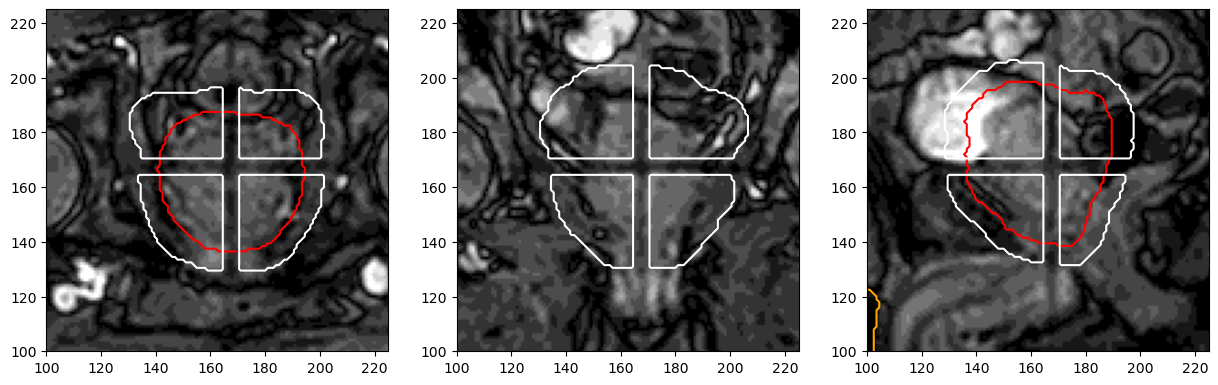

In [24]:
#f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
f, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(15, 10))
#ax1.imshow(external.mask[:,:,168].T, cmap='gray')
#ax2.imshow(external.mask[:,168,:].T, cmap='gray')
#ax3.imshow(external.mask[168,:,:].T, cmap='gray')

ax4.imshow(sitk.GetArrayFromImage(time_sorted_transversal[0].image)[:,:].T, cmap='gray')
ax4.contour(external.mask[:,:,168].T, levels=[0.5], colors='orange')
ax4.contour(z_mm.mask[:,:,168].T, levels=[0.5], colors='r')

cmask = remove_center_cross(registration_mask_3d[:,:,168], block_size=3) 
ax4.contour(cmask.T, levels=[0.5], colors='w')
ax4.set_xlim([100, 225])
ax4.set_ylim([100, 225])

ax5.imshow(sitk.GetArrayFromImage(time_sorted_coronal[0].image).swapaxes(0, 1), cmap='gray')
ax5.contour(external.mask[:,168,:].T, levels=[0.5], colors='orange')
#ax5.contour(z_mm.mask[:,168,:].T, levels=[0.5], colors='r')
cmask = remove_center_cross(registration_mask_3d[:,168,:], block_size=3)
ax5.contour(cmask.T, levels=[0.5], colors='w')
ax5.set_xlim([100, 225])
ax5.set_ylim([100, 225])


ax6.imshow(sitk.GetArrayFromImage(time_sorted_sagittal[0].image).swapaxes(0, 1), cmap='gray')
ax6.contour(external.mask[168,:,:].T, levels=[0.5], colors='orange')
ax6.contour(z_mm.mask[168,:,:].T, levels=[0.5], colors='r')

cmask = remove_center_cross(registration_mask_3d[168,:,:], block_size=3)
ax6.contour(cmask.T, levels=[0.5], colors='w')
ax6.set_xlim([100, 225])
ax6.set_ylim([100, 225])


#ax6.contour(rectum.mask[168,:,:].T, levels=[0.5], colors='g')
#ax6.contour(bladder.mask[168,:,:].T, levels=[0.5], colors='y')

#X-axis: Increases from the patient's right to left.
#Y-axis: Increases from the patient's anterior (front) to posterior (back).
#Z-axis: Increases from the patient's feet to head12.

In [ ]:
v = np.array([1, 2, 3])
v.take((0, 2))

In [ ]:

f, axes = plt.subplots(3, 3, figsize=(40/2.54, 20/2.54))

for i in range(3):
    im1 = axes[0][i].imshow(sitk.GetArrayFromImage(time_sorted_transversal[i].image)[0,:,:].T, cmap='gray')
    im2 = axes[1][i].imshow(sitk.GetArrayFromImage(time_sorted_coronal[i].image)[:,0,:].T, cmap='gray')
    im3 = axes[2][i].imshow(sitk.GetArrayFromImage(time_sorted_sagittal[i].image)[:,:,0].T, cmap='gray')
    f.colorbar(im1, ax=axes[0][i])
    f.colorbar(im3, ax=axes[1][i])
    f.colorbar(im3, ax=axes[2][i])    
    
time_sorted_sagittal[0].image.GetSize(), sitk.GetArrayFromImage(time_sorted_sagittal[i].image).shape

In [ ]:
print(sitk.GetArrayFromImage(time_sorted_transversal[0].image).shape)
plt.imshow(sitk.GetArrayFromImage(time_sorted_transversal[0].image)[0,138:198,138:198].T, cmap='gray')
#plt.imshow(sitk.GetArrayFromImage(time_sorted_transversal[0].image)[0,168,:].T)

In [ ]:
f, axes = plt.subplots(3, 3, figsize=(40/2.54, 20/2.54))

for i in range(3):
    im1 = axes[0][i].imshow(masks[i][:,:,0], cmap='gray')
    im2 = axes[1][i].imshow(masks[3+i][:,:,0], cmap='gray')
    im3 = axes[2][i].imshow(masks[6+i][:,:,0], cmap='gray')
    f.colorbar(im1, ax=axes[0][i])
    f.colorbar(im3, ax=axes[1][i])
    f.colorbar(im3, ax=axes[2][i])    

In [ ]:
import datetime
from zoneinfo import ZoneInfo

3800849372019413800
# Assuming the number is in nanoseconds
nanoseconds = 9860646682574969946
nanoseconds = 38008493720194138

#t0 = datetime('01-Jan-1900 00:00:00', 'TimeZone','+00:00') + days((double(zs{1}.TwoDSlicedata.Elapsed100NanosecondInterval)*100e-9)/86400);
#t0.TimeZone = 'Europe/Stockholm';
#t0.Format = 'uuuu-MM-dd'' ''HH:mm:ss.SSS Z';

t0_utc = datetime.datetime(1900, 1, 1, 0, 0, 0, 0, tzinfo=ZoneInfo(key='UTC')) # in UTC
t1_utc = t0_utc + datetime.timedelta(seconds=nanoseconds * 100 * 1e-9)
t1_local = t1_utc.astimezone(ZoneInfo('Europe/Amsterdam'))

#utc_aware = utc_unaware.replace(tzinfo=ZoneInfo('UTC'))  # make aware
#local_aware = utc_aware.astimezone(ZoneInfo('localtime'))  # convert



datetime.datetime(2024, 8, 15, 11, 4, 47, 972573, tzinfo=ZoneInfo(key='Europe/Amsterdam'))
print(t0.tzinfo)

# Convert nanoseconds to seconds
#seconds = nanoseconds * 100 / 1e9

# Convert seconds to a datetime object
#date_time = datetime.datetime.fromtimestamp(seconds)

#print(date_time)

In [26]:
from datetime import timezone

timezone

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 

for i in range(21):
    ax.set_xlim(0, 20)
    
    ax.plot(i, 1,marker='x')
    display(fig)
    
    clear_output(wait = True)
    plt.pause(0.5)